# Running barotropic models

In this notebook we'll run a couple of different barotropic model configurations and write their output to NetCDF files. We won't have to change any of the code in the `barotropic` package. We can create multiple independent model instances, because all model state is stored within the model instance (i.e., no global state in the `barotropic` module).

The first job is to import the modules/objects we'll need:

In [1]:
from datetime import datetime

import netCDF4
import numpy as np

from barotropic.model import BarotropicModel
from barotropic.io import NetCDFWriter

Before we start creating models we'll just create a few variables to control how long we run each model for and how often we write output to file. Both models will be run for 7 days and write output every 3 hours:

In [2]:
hour = 3600
run_time = 7 * 24 * hour
output_interval = 3 * hour

### An idealized initial condition

The first model we'll run uses an idealized initial condition as in Held (1985).
The initial vorticity is derived from a zonal wind:
    
$u(\theta) = 25 \cos(\theta)\, - 30 \cos^3(\theta) + 300 \sin^2(\theta)\,\cos^6(\theta)$

where $\theta$ is latitude. The associated vorticity (assuming zero meridional flow) is computed and the following perturbation is added:

$\zeta^\prime = \dfrac{A}{2}\, \cos (\theta) \, \exp{\left[-\left((\theta - \theta_0)/\theta_w\right)^2\right]} \, \cos (m \lambda)$

with $m = 4$, $\theta_0 = 45^\circ\textrm{N}$, $\theta_w = 15^\circ$, and $A = 8\times 10^{-5}$, and where $\lambda$ is longitude.

To save time and effort, this initial condition has been pre-generated on an N64 Gaussian grid, and is contained in the NumPy save file `input_data/idealized.npy`. We can load this file using `np.load`, determine the grid size and work out a good trunction:

In [3]:
vrt = np.load('input_data/idealized.npy')
nlat, nlon = vrt.shape
truncation = nlon // 3

Next we can create a barotropic model using this initial condition.
For this model resolution a time-step of 1800 seconds is a good enough choice.
We'll pick an arbitrary start date, it doesn't mean anything in this case.

In [4]:
dt = 1800
start_time = datetime(2000, 1, 1)
model_ideal = BarotropicModel(nlon, nlat, truncation, dt, start_time, vrt=vrt)

We want to run this model, saving output every 3 hours.
For this we're going to need a way to write model data to file.
Within the `barotropic.io` module is a class called `NetCDFWriter` that we can use for this.
It is already imported so we can go ahead and use it, it takes a model and a filename as input.
Later we can call the `save()` method of the `NEtCDFWriter` to save model state to file:

In [5]:
saver_ideal = NetCDFWriter(model_ideal, 'model_idealized.nc')

Now we have both a model and a saver we can run the model.
The model object has a method called `run_with_snapshots()` which allows us to run a model for a specified amount of time, pausing at specified intervals.
We can tell the model to pause every 3 hours and during this pause we can write output using our saver:

In [6]:
# The run_with_snapshots method is an iterator that yields the
# current model time at the given interval. This means we can
# loop over the iterator saving the current model state.
for t in model_ideal.run_with_snapshots(run_time, snapshot_interval=output_interval):
    print('Saving output at time: {}'.format(model_ideal.valid_time))
    saver_ideal.save()
    
# Make sure the output file is closed when we are done:
saver_ideal.close()

Saving output at time: 2000-01-01 03:00:00
Saving output at time: 2000-01-01 06:00:00
Saving output at time: 2000-01-01 09:00:00
Saving output at time: 2000-01-01 12:00:00
Saving output at time: 2000-01-01 15:00:00
Saving output at time: 2000-01-01 18:00:00
Saving output at time: 2000-01-01 21:00:00
Saving output at time: 2000-01-02 00:00:00
Saving output at time: 2000-01-02 03:00:00
Saving output at time: 2000-01-02 06:00:00
Saving output at time: 2000-01-02 09:00:00
Saving output at time: 2000-01-02 12:00:00
Saving output at time: 2000-01-02 15:00:00
Saving output at time: 2000-01-02 18:00:00
Saving output at time: 2000-01-02 21:00:00
Saving output at time: 2000-01-03 00:00:00
Saving output at time: 2000-01-03 03:00:00
Saving output at time: 2000-01-03 06:00:00
Saving output at time: 2000-01-03 09:00:00
Saving output at time: 2000-01-03 12:00:00
Saving output at time: 2000-01-03 15:00:00
Saving output at time: 2000-01-03 18:00:00
Saving output at time: 2000-01-03 21:00:00
Saving outp

We now have a file `'model_idealized.nc'` that contains our model output:

In [7]:
!ncdump -h model_idealized.nc

netcdf model_idealized {
dimensions:
	time = UNLIMITED ; // (56 currently)
	latitude = 128 ;
	longitude = 256 ;
variables:
	float time(time) ;
		time:units = "seconds since 2000-01-01 00:00:00" ;
		time:standard_name = "time" ;
	float latitude(latitude) ;
		latitude:units = "degrees_north" ;
		latitude:standard_name = "latitude" ;
	float longitude(longitude) ;
		longitude:units = "degrees_east" ;
		longitude:standard_name = "longitude" ;
	float uwnd(time, latitude, longitude) ;
		uwnd:units = "m s-1" ;
		uwnd:standard_name = "eastward_wind" ;
	float vwnd(time, latitude, longitude) ;
		vwnd:units = "m s-1" ;
		vwnd:standard_name = "northward_wind" ;
	float vrt(time, latitude, longitude) ;
		vrt:units = "s-1" ;
		vrt:standard_name = "atmosphere_relative_vorticity" ;
}


### A realistic initial condition

We can also run the barotropic model with a more realistic initial condition.
We'll set up a second model that is initialized using vorticity from ECMWF analysis valid at 2016-11-01 0000z.
This initial condition is stored in the NetCDF file `input_data/ecmwf.201611010000.nc`.
This file contains data on an N80 Gaussian grid, corresponding to a spectral resolution of T106.
This is higher resolution than the previous model, so we'll need to make the time-step shorter:

In [8]:
# Load initial condition from file:
ds = netCDF4.Dataset('input_data/ecmwf.201611010000.nc')
vrt = ds.variables['atmosphere_relative_vorticity'][:]
nlat, nlon = vrt.shape
truncation = nlon // 3

# Use a shorter 900 second time-step and the correct start time:
dt = 900
start_time = datetime(2016, 11, 1, 0)

# Create the model and a saver:
model_ecmwf = BarotropicModel(nlon, nlat, truncation, dt, start_time, vrt=vrt)
saver_ecmwf = NetCDFWriter(model_ecmwf, 'model_ecmwf.nc')

# Run the model (same method as before)
for t in model_ecmwf.run_with_snapshots(run_time, snapshot_interval=output_interval):
    print('Saving output at time: {}'.format(model_ecmwf.valid_time))
    saver_ecmwf.save()
saver_ecmwf.close()

Saving output at time: 2016-11-01 03:00:00
Saving output at time: 2016-11-01 06:00:00
Saving output at time: 2016-11-01 09:00:00
Saving output at time: 2016-11-01 12:00:00
Saving output at time: 2016-11-01 15:00:00
Saving output at time: 2016-11-01 18:00:00
Saving output at time: 2016-11-01 21:00:00
Saving output at time: 2016-11-02 00:00:00
Saving output at time: 2016-11-02 03:00:00
Saving output at time: 2016-11-02 06:00:00
Saving output at time: 2016-11-02 09:00:00
Saving output at time: 2016-11-02 12:00:00
Saving output at time: 2016-11-02 15:00:00
Saving output at time: 2016-11-02 18:00:00
Saving output at time: 2016-11-02 21:00:00
Saving output at time: 2016-11-03 00:00:00
Saving output at time: 2016-11-03 03:00:00
Saving output at time: 2016-11-03 06:00:00
Saving output at time: 2016-11-03 09:00:00
Saving output at time: 2016-11-03 12:00:00
Saving output at time: 2016-11-03 15:00:00
Saving output at time: 2016-11-03 18:00:00
Saving output at time: 2016-11-03 21:00:00
Saving outp

# Visualizing the model output

We can visualize the model output by producing an animation of the vorticity field.
We can do this right here in the notebook using familiar tools, and some more advanced parts of matplotlib.

In [9]:
import matplotlib
matplotlib.use('nbagg')  # Use the notebook backend to render interactive plots

In [10]:
# We'll use cartopy for handling map projections:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

# The data will be loaded from NetCDF using iris:
import iris
import iris.plot as iplt

# We'll use the pyplot as before, and the FuncAnimation class from
# the matplotlib animation module:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

We'll create a helper object to make producing the animation more organized.
We're going to be using the `FuncAnimation` class from matplotlib, which produces frames for animation by calling a function repeatedly with a varying index argument.
For efficiency we'll write this function so that it doesn't have to redraw the whole plot on every frame, but instead only redraws the data.
We'll also provide a function that initializes the animation with empty data.
We could write these as separate functions, but it turns out to be a good use case for a bit of OO programming!

We'll write a class that encapsulates these functions along with the data to be plotted and an axes to plot onto.
The class has a constructor `__init__()` that takes a matplotlib axes set and an iterable of iris `Cube`s as input.
It uses these to set up a plot which can then be modified by other methods.
The `init()` method simply initializes the animation to be blank.
We'll make use of the special `__call__()` method so that updating the animation is done by calling the class as if it were a function.

In [11]:
class ModelQuadmeshAnimator(object):
    """Animate model barotropic model output."""

    def __init__(self, ax, cube_iterator):
        """Initialize the animator."""
        # Store the axes object for use later:
        self.ax = ax
        # Turn the cube_iterator into a list (it might already be one, that
        # is OK) and store it for use later:
        self.cube_list = list(cube_iterator)
        # Find the min and max values of the cubes, used for setting the
        # color scale:
        vmin = min([cube.data.min() for cube in self.cube_list])
        vmax = max([cube.data.max() for cube in self.cube_list])
        # To set up the internals of the plot we just plot the first cube,
        # we'll do the animation by replacing just the data.
        self.quad = iplt.pcolormesh(self.cube_list[0], axes=ax, vmin=vmin, vmax=vmax, cmap='viridis')
        plt.colorbar(self.quad, format='%.0e')

    def __len__(self):
        return len(self.cube_list)
    
    def init(self):
        """
        Initialize the animation.
        
        This will be called once when the animation is started. It will
        ensure the plot is initially a blank map with no data overlay.
        
        """
        self.quad.set_array(np.asarray([]))
        return self.quad

    def __call__(self, i):
        """Update the animation frame.
        
        What are the arguments, who provides them?
        
        """
        # Get the cube to be plotted for the current animation frame:
        cube = self.cube_list[i]
        # Extract the cube's data, add a cyclic point:
        data = add_cyclic_point(cube.data)
        # Replace the current quadmesh with a new one:
        self.quad.set_array(data.ravel())
        # Use a right-side title to display the valid time:
        time_coord = cube.coord('time')
        self.ax.set_title(time_coord.units.num2date(time_coord.points[0]),
                          loc='right')
        return self.quad

Now we have our animation helpers defined we can go ahead and make an animation.
However, since we are going to want to make more than one animation it is convenient to wrap the generation of the animation up in a function.
The function defined here loads the vorticity field time series from a barotropic model output file, creates a base axes using a polar stereographic projection with coastlines drawn on top and some static titles that will be the same on every frame.
It then creates an animation using the class we just defined.

In [12]:
def animate_vorticity(model_filename):
    
    with iris.FUTURE.context(netcdf_promote=True):
        vrt = iris.load_cube(model_filename, 'atmosphere_relative_vorticity')
        
    fig = plt.figure()
    fig.suptitle(model_filename, fontsize=16)
    
    ax = fig.add_subplot(111, projection=ccrs.NorthPolarStereo())
    ax.coastlines()
    ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
    ax.set_title('Relative vorticity / s-1', loc='left')
    
    animator = ModelQuadmeshAnimator(ax, vrt.slices_over(['time']))
    animation = FuncAnimation(fig, animator, init_func=animator.init,
                              frames=len(animator))
    
    plt.show()
    
    return animation

Now let's use this function to make an animation of vorticity from the barotropic model using the idealized initial condition:

/Users/dawson/miniconda3/envs/a3/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/Users/dawson/miniconda3/envs/a3/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


<IPython.core.display.Javascript object>


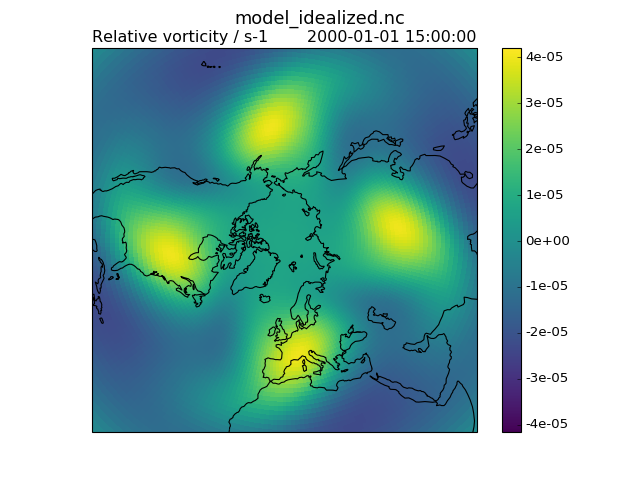

In [13]:
animation_ideal = animate_vorticity('model_idealized.nc')

And we can do the same for the model initialized with the ECMWF initial condition:

/Users/dawson/miniconda3/envs/a3/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/Users/dawson/miniconda3/envs/a3/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


<IPython.core.display.Javascript object>


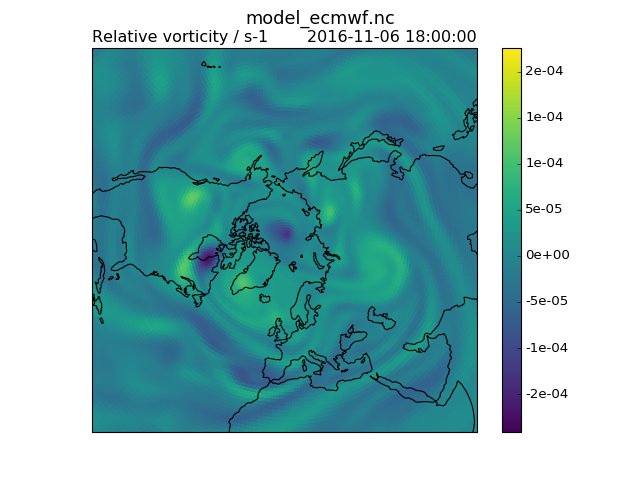

In [14]:
animation_ecmwf = animate_vorticity('model_ecmwf.nc')